# Part I: Profiling expression STRs across 17 human tissues

In [16]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True
FIGPREFIX = "Figure1"

############ Tissue info ##############
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

SHORTEN = {
    "Artery-Aorta":"Artery A."     ,
    "Artery-Tibial": "Artery T.",
    "Adipose-Subcutaneous": "Adipose S.",    
    "Adipose-Visceral":"Adipose V.",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "E. Mucosa",
    "Esophagus-Muscularis":"E Muscularis",
    "Heart-LeftVentricle":"Ventricle",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "Skin Unexposed",
    "Skin-SunExposed":"Skin Leg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
    "permuted":"Permuted",
    "LCL": "LCL"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

############ Load data ################
NGESTR = pd.read_csv(os.path.join(DATADIR, "misc", "2016_estrs_table.csv"))

# Linear regression data
master = {} # Map of tissue -> data
for t in TISSUES:
    master[t] = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t", 
                            usecols=["chrom","gene","gene.name","str.start","linreg.beta","linreg.pval","anova.pval","caviar.str.score","caviar.str.rank","mashr.significant"])
    master[t] = master[t][(master[t]["mashr.significant"].apply(str) != "nan")] # TODO remove after rerun mashr
    # Reformat gene names and start coords
    master[t]["gene"] = master[t]["gene"].apply(lambda x: x.split(".")[0])
    master[t]["signif_%s"%t] = master[t]["mashr.significant"]
master["permuted"] = pd.read_csv(os.path.join(DATADIR, "strreg","WholeBlood_strreg_permuted.tab"), sep="\t")
master["permuted"]["linreg.pval"] = master["permuted"]["p.wald"]
master["LCL"] = NGESTR

master["LCL"]["str.id"] = master["LCL"]["str.start"].apply(lambda x: "STR_%s"%(x-1))
master["LCL"]["significant"] = master["LCL"]["signif.estr"]

betas = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_betas.tsv"), sep="\t", index_col=0)
beta_ses = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_beta_ses.tsv"), sep="\t", index_col=0)
zscores = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "zscores.tsv"), sep="\t", index_col=0)
ntissues = len(betas.columns)

NOMTHRESH = 10**-4
ZTHRESH = 3

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


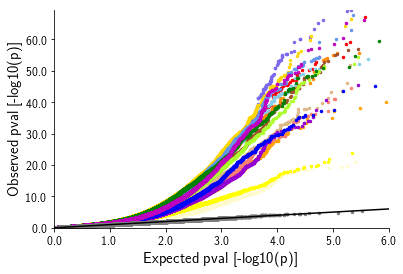

In [2]:
# Figure 1B: QQ Plot

TISSUES = sorted(TISSUES)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
maxval = 0
for t in TISSUES + ["permuted"]:
    dt = master[t][["linreg.pval"]].copy()
    dt = dt[~np.isnan(dt["linreg.pval"])]
    unif = sorted(list(np.random.uniform(low=0, high=1, size=dt.shape[0])))
    unif_log = [-1*np.log10(x) for x in unif]
    pvals = sorted(list(dt["linreg.pval"]))
    pvals_log = [-1*np.log10(x) for x in pvals]
    maxval = max([maxval]+pvals_log)
    ax.scatter(unif_log, pvals_log, color=COLORS[t], label=SHORTEN[t], s=6)
ax.plot([0,6],[0,6], color="black")
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot.png"%FIGPREFIX))

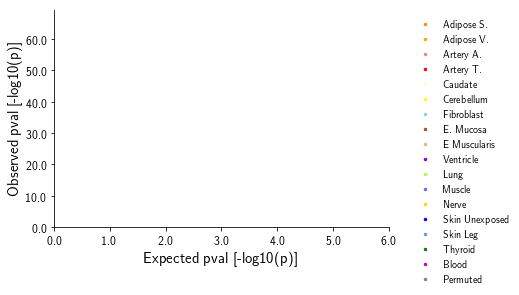

In [3]:
# Additionally plot the skeleton as pdf to use in Illustrator
fig = plt.figure()
ax = fig.add_subplot(111)
for t in TISSUES + ["permuted"]:
    ax.scatter([],[], color=COLORS[t], label=SHORTEN[t], s=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot_skeleton.pdf"%FIGPREFIX))

In [18]:
#### Stats ####
numgenes = []
numtests = []
numsig_mashr = {}
numsig_nom = {}
num_samples = {}

# Keep track of number of unique eSTRs
starts = []
genes = []

for t in TISSUES:
    d = master[t]
    numgenes.append(len(set(d[~np.isnan(d["linreg.pval"])]["gene"])))
    numtests.append(d[~np.isnan(d["linreg.pval"])].shape[0])
    numsig_mashr[t] = sum(d["mashr.significant"] & ~np.isnan(d["linreg.pval"]))
    numsig_nom[t] = sum((d["linreg.pval"]<NOMTHRESH) & ~np.isnan(d["linreg.pval"]))
    num_samples[t] = len(open(os.path.join(DATADIR,"samples","%s.samples"%t), "r").readlines())
    estrs = d[d["mashr.significant"]]
    starts.extend(list(estrs["str.start"]))
    genes.extend(list(estrs["gene"]))

print("Mean num genes tested per tissue: %s"%np.mean(numgenes))
print("Mean num STRxgene tests per tissue: %s"%np.mean(numtests))

# Number of unique eSTRs
allestrs = pd.DataFrame({"str.start": starts, "gene": genes}).drop_duplicates()
print("Number unique eSTRs: %s"%(allestrs[["str.start","gene"]].shape[0]))
print("Number unique genes: %s"%(len(set(allestrs["gene"]))))

print()
for t in numsig_mashr:
    print("%s: %s %s"%(t, num_samples[t], numsig_mashr[t]))

Mean num genes tested per tissue: 15840.117647058823
Mean num STRxgene tests per tissue: 262506.23529411765
Number unique eSTRs: 15191
Number unique genes: 7839

Adipose-Subcutaneous: 270 4936
WholeBlood: 336 3037
Skin-SunExposed: 297 4263
Lung: 259 4879
Artery-Aorta: 191 4232
Adipose-Visceral: 193 4370
Esophagus-Mucosa: 255 3977
Brain-Caudate: 108 2096
Muscle-Skeletal: 343 3363
Cells-Transformedfibroblasts: 225 3396
Artery-Tibial: 276 4644
Esophagus-Muscularis: 214 4560
Thyroid: 262 4736
Nerve-Tibial: 265 5045
Brain-Cerebellum: 107 1781
Skin-NotSunExposed: 209 3703
Heart-LeftVentricle: 199 3333


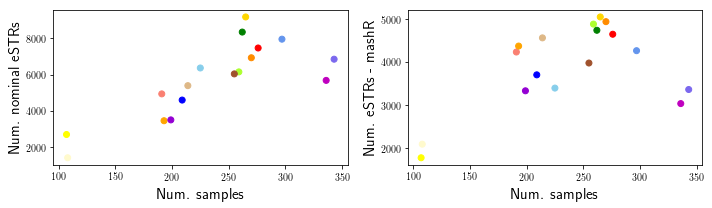

In [19]:
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(121)
ax.scatter([num_samples[t] for t in TISSUES], [numsig_nom[t] for t in TISSUES], color=[COLORS[t] for t in TISSUES])
ax.set_xlabel("Num. samples", size=15)
ax.set_ylabel("Num. nominal eSTRs", size=15);

ax = fig.add_subplot(122)
ax.scatter([num_samples[t] for t in TISSUES], [numsig_mashr[t] for t in TISSUES], color=[COLORS[t] for t in TISSUES])
ax.set_xlabel("Num. samples", size=15)
ax.set_ylabel("Num. eSTRs - mashR", size=15);

fig.tight_layout()
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_SamplePower.pdf"));

In [20]:
numshared = zscores.apply(lambda x: sum(abs(x)>=ZTHRESH), 1) # takes a long time to run

shared across 2 or more tissues: 0.8297232782247369
shared across 10 or more tissues: 0.38847139952258863


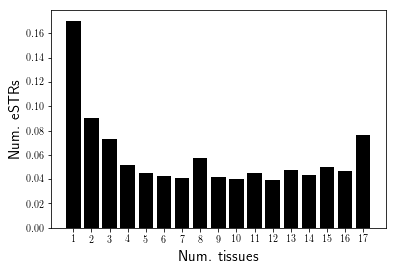

In [21]:
# Tissue sharing
zscores_sig = zscores.copy()
zscores_sig["num"] = numshared
zscores_sig = zscores_sig[zscores_sig["num"]>0]
signum = zscores_sig.groupby("num", as_index=False).agg({"WholeBlood":len})
signum.columns = ["num.tissues", "num.estrs"]
signum["perc.estrs"] = signum["num.estrs"]/sum(signum["num.estrs"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(signum["num.tissues"], signum["perc.estrs"], color="black");
ax.set_xticks(range(1, ntissues+1));
ax.set_xlabel("Num. tissues", size=15)
ax.set_ylabel("Num. eSTRs", size=15);

if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_TissueSharing.pdf"));
    
print("shared across 2 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=2]["perc.estrs"])))
print("shared across 10 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=10]["perc.estrs"])))

In [22]:
# Pairwise sharing
# Of effects sig in at least one, how many shared within factor of 2
shareMatrix = np.full((ntissues, ntissues), np.nan)
# Correlation of effect sizes
corrMatrix = np.full((ntissues, ntissues), np.nan)

for tissue1 in TISSUES:
    for tissue2 in TISSUES:
        t1ind = TISSUES.index(tissue1)
        t2ind = TISSUES.index(tissue2)
        significant = (zscores[tissue1] >=ZTHRESH) | (zscores[tissue2] >=ZTHRESH)
        sharedEffects = abs(np.log2(betas[tissue1]/betas[tissue2])) < 1
        shareMatrix[t1ind, t2ind] = np.sum(sharedEffects & significant)/np.sum(significant)
        shareMatrix[t2ind, t1ind] = shareMatrix[t1ind, t2ind]
        eff1 = betas[significant][tissue1]
        eff2 = betas[significant][tissue2]
        corrMatrix[t1ind, t2ind] = scipy.stats.spearmanr(eff1, eff2)[0]
        corrMatrix[t2ind, t1ind] = corrMatrix[t1ind, t2ind]

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log2
  if sys.path[0] == '':


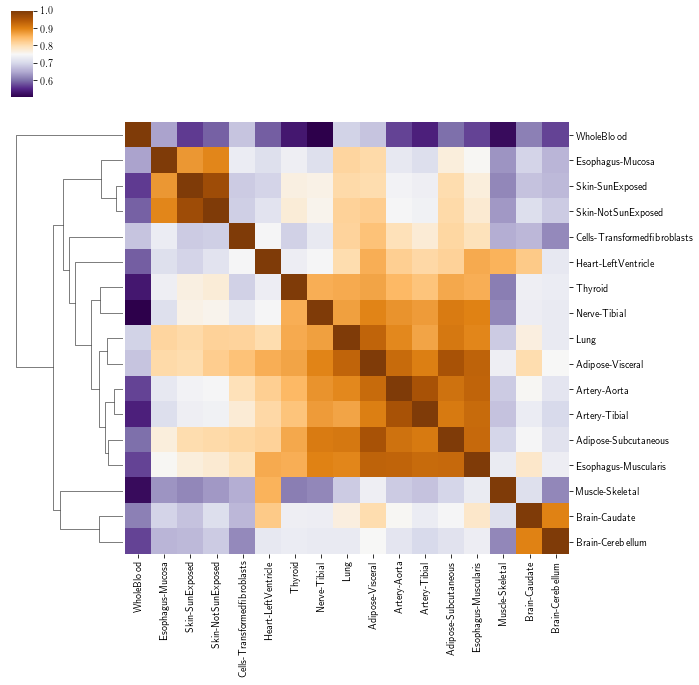

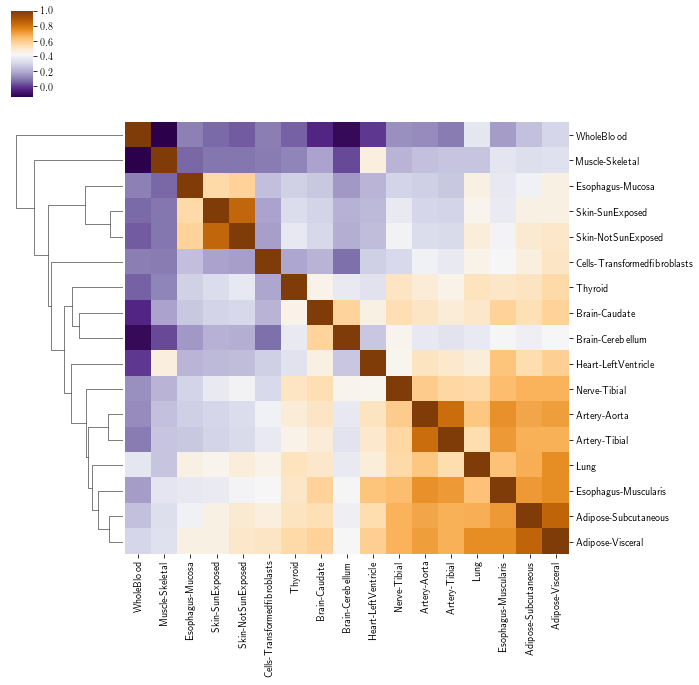

In [23]:
import seaborn as sns
shareMatrix = pd.DataFrame(shareMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(shareMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: cg.savefig(os.path.join(RESULTSDIR, "Figure1_mashRHeatmap.pdf"));

corrMatrix = pd.DataFrame(corrMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(corrMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: cg.savefig(os.path.join(RESULTSDIR, "SuppFig_mashRHeatmap_spearman.pdf"));

In [24]:
# How do effect sizes compare to those from LCLs?
lcl = master["LCL"]
lclcorr = {}
for t in TISSUES:
    d = master[t]
    d = d[~np.isnan(d["linreg.pval"])].copy()
    d["str.start"] = d["str.start"]+1
    dm = pd.merge(d, lcl, on=["gene","str.start"])
    dm = dm[dm["mashr.significant"] | dm["significant"]]
    lclcorr[t] = scipy.stats.pearsonr(dm["linreg.beta"], dm["beta"])[0]
print("Mean corr with LCL: %s"%(np.mean(list(lclcorr.values()))))
lclcorr

Mean corr with LCL: 0.47517559062042225


{'Adipose-Subcutaneous': 0.4926718484714364,
 'Adipose-Visceral': 0.5081465437159131,
 'Artery-Aorta': 0.4752311109211651,
 'Artery-Tibial': 0.46589346412228055,
 'Brain-Caudate': 0.4200931422771599,
 'Brain-Cerebellum': 0.3375605551938979,
 'Cells-Transformedfibroblasts': 0.5442109353409663,
 'Esophagus-Mucosa': 0.5254523010359358,
 'Esophagus-Muscularis': 0.4961333854847486,
 'Heart-LeftVentricle': 0.4786078075936931,
 'Lung': 0.5215541502605319,
 'Muscle-Skeletal': 0.45761892260691317,
 'Nerve-Tibial': 0.44813214048874334,
 'Skin-NotSunExposed': 0.48181561383350097,
 'Skin-SunExposed': 0.46417744873449307,
 'Thyroid': 0.4455600511489194,
 'WholeBlood': 0.5151256193168798}

In [26]:
# For each tissue:
#  - how many pass ANOVA at q<0.1?
#  - how many eSTR have highest caviar score?

MINANOVAQ = 0.1 # 10% FDR for ANOVA analysis
MINANOVAP = 0.05 # nominal p-value for ANOVA analysis

perc_caviar = []
perc_anova_nom = []
perc_anova_fdr = []

for t in TISSUES:
    d = master[t]
    tissue_estrs = d[d["mashr.significant"]].copy()
    num_estrs = tissue_estrs.shape[0]
    num_best_caviar = tissue_estrs[tissue_estrs["caviar.str.rank"]==1].shape[0]
    num_anova_nom = tissue_estrs[tissue_estrs["anova.pval"]<MINANOVAP].shape[0]
    anova_p = list(tissue_estrs["anova.pval"])
    anova_p = [item for item in anova_p if not np.isnan(item)]
    rejected, anova_q = statsmodels.stats.multitest.fdrcorrection(list(anova_p))
    num_anova_fdr = len([item for item in anova_q if item < MINANOVAQ])
    print("%s numestrs=%s perccaviar=%.2f perc_anova_nom=%.2f perc_anova_q=%s"%(t, num_estrs, \
                                                                            num_best_caviar*1.0/num_estrs, \
                                                                            num_anova_nom*1.0/num_estrs, \
                                                                           num_anova_fdr*1.0/num_estrs))
    perc_caviar.append(num_best_caviar*1.0/num_estrs)
    perc_anova_nom.append(num_anova_nom*1.0/num_estrs)
    perc_anova_fdr.append(num_anova_fdr*1.0/num_estrs)
    
print("\n")
print("Average percent best CAVIAR: %s"%np.mean(perc_caviar))
print("Average percent pass ANOVA p<%s: %s"%(MINANOVAP, np.mean(perc_anova_nom)))
print("Average percent pass ANOVA q<%s: %s"%(MINANOVAQ, np.mean(perc_anova_fdr)))

Adipose-Subcutaneous numestrs=5110 perccaviar=0.04 perc_anova_nom=0.24 perc_anova_q=0.1655577299412916
WholeBlood numestrs=3140 perccaviar=0.05 perc_anova_nom=0.19 perc_anova_q=0.11273885350318472
Skin-SunExposed numestrs=4382 perccaviar=0.05 perc_anova_nom=0.24 perc_anova_q=0.15951620264719307
Lung numestrs=5066 perccaviar=0.04 perc_anova_nom=0.21 perc_anova_q=0.11508093170153967
Artery-Aorta numestrs=4506 perccaviar=0.04 perc_anova_nom=0.20 perc_anova_q=0.12028406569019086
Adipose-Visceral numestrs=4647 perccaviar=0.03 perc_anova_nom=0.17 perc_anova_q=0.07940606843124597
Esophagus-Mucosa numestrs=4113 perccaviar=0.05 perc_anova_nom=0.24 perc_anova_q=0.15900802334062727
Brain-Caudate numestrs=2363 perccaviar=0.04 perc_anova_nom=0.17 perc_anova_q=0.086754126110876
Muscle-Skeletal numestrs=3431 perccaviar=0.06 perc_anova_nom=0.24 perc_anova_q=0.16263480034975225
Cells-Transformedfibroblasts numestrs=3600 perccaviar=0.05 perc_anova_nom=0.27 perc_anova_q=0.18861111111111112
Artery-Tibial 

In [ ]:
# Get list of all causal

MIN_CAUSAL_SCORE = 0.9

chroms = []
starts = []
tissues = []
genes = []
genenames = []
scores = []
betas = []
pvals = []

for t in TISSUES:
    d = master[t]
    tissue_estrs = d[d["mashr.significant"]].copy()
    tissue_causal = tissue_estrs[(tissue_estrs["caviar.str.score"]>=MIN_CAUSAL_SCORE) & ~np.isnan(tissue_estrs["caviar.str.score"])].copy()
    chroms.extend(list(tissue_estrs["chrom"]))
    starts.extend(list(tissue_estrs["str.start"]))
    tissues.extend([t]*tissue_estrs.shape[0])
    genes.extend(list(tissue_estrs["gene"]))
    genenames.extend(list(tissue_estrs["gene.name"]))
    scores.extend(list(tissue_estrs["caviar.str.score"]))
    betas.extend(list(tissue_estrs["linreg.beta"]))
    pvals.extend(list(tissue_estrs["linreg.pval"]))
    print("%s %s"%(t, tissue_causal.shape[0]))
    
all_causal = pd.DataFrame({
    "chrom": chroms,
    "str.start": starts,
    "gene": genes,
    "gene.name": genenames,
    "score": scores,
    "beta": betas,
    "tissue": tissues,
    "pval": pvals,
})

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]
def concat(x):
    return ";".join([str(item) for item in x])

all_causal["tissue_info"] = all_causal.apply(lambda x: "%s_%.2f_%.2f"%(x["tissue"], x["beta"], x["score"]), 1)
all_causal["num.e"] = 1
aggdir = {"tissue_info": concat,"score": max,"beta": maxabs,"pval": min, "num.e": sum}
all_unique_causal = all_causal.groupby(["chrom","str.start","gene","gene.name"], as_index=False).agg(aggdir)
all_unique_causal["causal"] = (all_unique_causal["score"]>=MIN_CAUSAL_SCORE)

# Number unique causal
print("Number total causal eSTRs: %s"%all_unique_causal[all_unique_causal["causal"]].shape[0])
print("Number total causal genes: %s"%len(set(all_unique_causal[all_unique_causal["causal"]]["gene"])))

In [ ]:
# Add info for table
d = pd.read_csv(os.path.join(DATADIR,"mastertables","WholeBlood_master.tab"), sep="\t")
d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
causaltable = pd.merge(all_unique_causal, d[["gene","str.start","str.end","str.motif.forward","str.motif.reverse"]], on=["gene","str.start"])
# TODO write table to file


# Sanity check that our favorites are there

In [ ]:
causaltable[causaltable["gene.name"]=="RFT1"]

In [ ]:
d = master["Artery-Aorta"]
d[d["gene.name"]=="RFT1"]